In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import datetime
import pandas as pd
from scipy.signal import argrelextrema

In [2]:
data_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_fn = "time_series_covid19_confirmed_global.csv"
deaths_fn = "time_series_covid19_deaths_global.csv"
recovered_fn = "time_series_covid19_recovered_global.csv"

In [96]:
#get files with data
import requests

def get_raw_from_git(link, filename, verbose=True):
    r = requests.get(link + filename)
    if verbose:
        if (r.status_code == requests.codes.ok):
            print(filename + " done")
        else:
            print(filename + " failed to get raw")
            return
    open(filename , 'wb').write(r.content)
    

get_raw_from_git(data_link, confirmed_fn)
get_raw_from_git(data_link, deaths_fn)
get_raw_from_git(data_link, recovered_fn)

#or just clone from here: https://github.com/CSSEGISandData/COVID-19

time_series_covid19_confirmed_global.csv done
time_series_covid19_deaths_global.csv done
time_series_covid19_recovered_global.csv done


Variables renamed to better match SIR model

infected - cumulative total confirmed cases
deaths - cumulative deaths
recovered - cumulative recovered
d_infected - dI/dt, new daily cases

In [3]:
#get lists with data from files

def get_data_list(filename, country="Ukraine"):
    df = pd.read_csv(filename, header = 0)
    dates = [datetime.datetime.strptime(i, "%m/%d/%y") for i in df.columns[4:]]
    datalist = df.loc[df['Country/Region'] == country].values.tolist()[0][4:]
    return(datalist, dates)
    
infected, dates = get_data_list(confirmed_fn)   
deaths = get_data_list(deaths_fn)[0]
recovered = get_data_list(recovered_fn)[0]

d_infected = [0] + [j-i for i, j in zip(infected, infected[1:])]
   
#print(len(infected), len(d_infected), len(dates), len(deaths), len(recovered)) 

In [4]:
#skip first N days where there were no cases

days_to_skip = len([i for i in infected if i<2])
print("days_to_skip =", days_to_skip)

dates = dates[days_to_skip:]
infected = infected[days_to_skip:]
deaths = deaths[days_to_skip:]
recovered = recovered[days_to_skip:]
d_infected = d_infected[days_to_skip:]

days_to_skip = 51


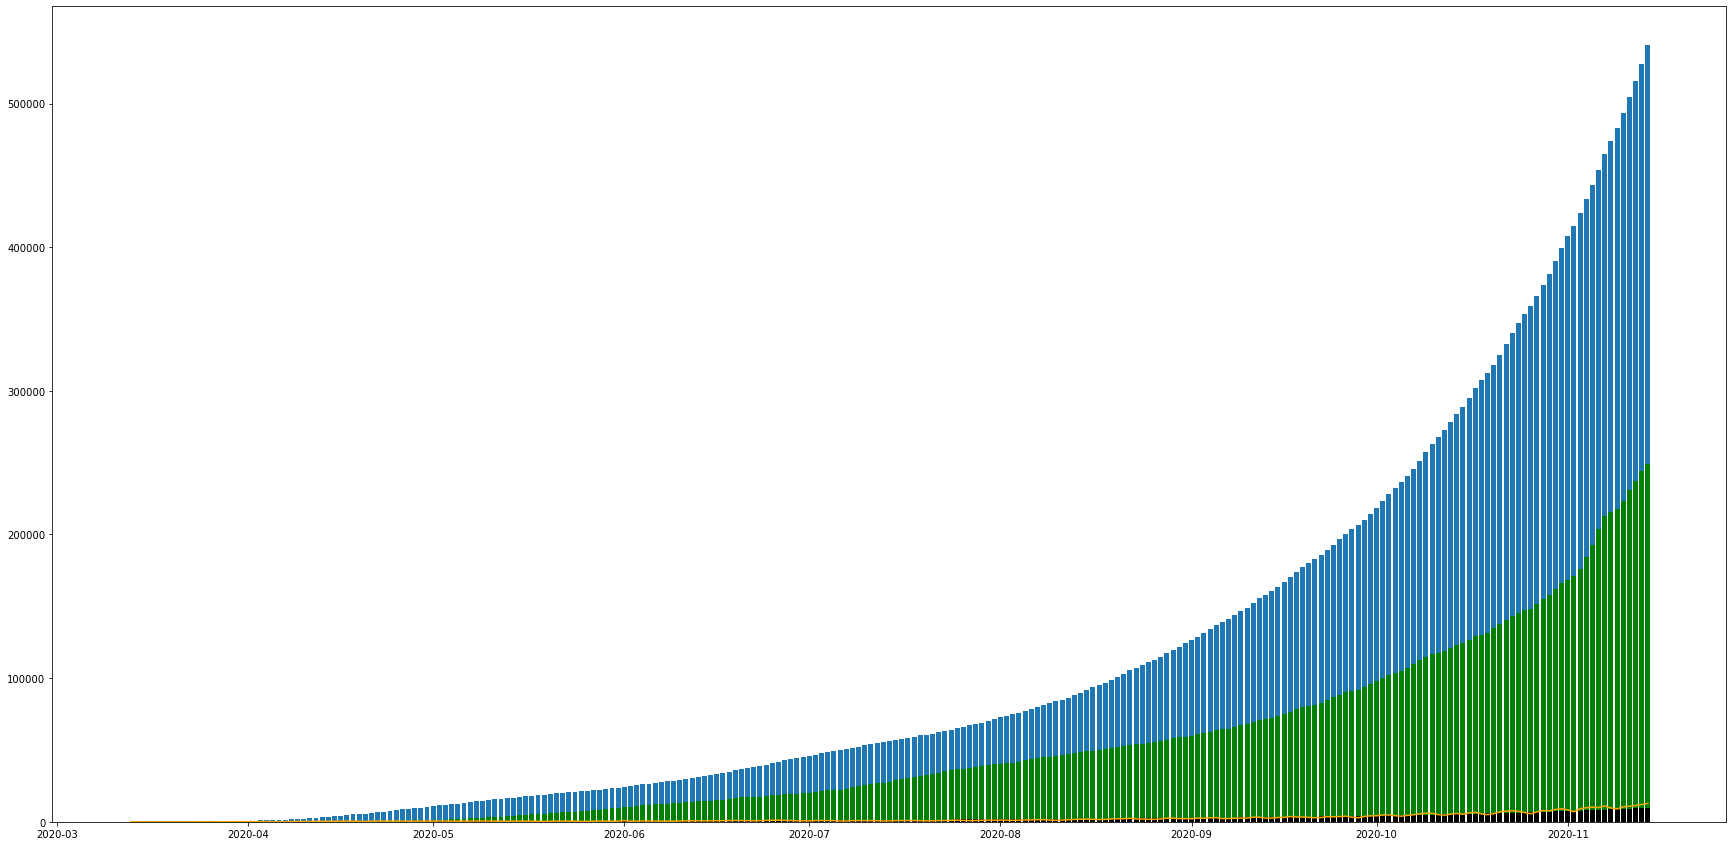

In [5]:
#visual check of imported data

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, infected)
plt.bar(dates, recovered, color="green")
plt.bar(dates, deaths, color="black")
plt.plot(dates, d_infected, color="orange")

plt.show()

removal_rate_median = 0.009032943676939426
removal_rate(γ) mu = 0.010231748777076978
days in infected(1/γ) = 97.73500325187632


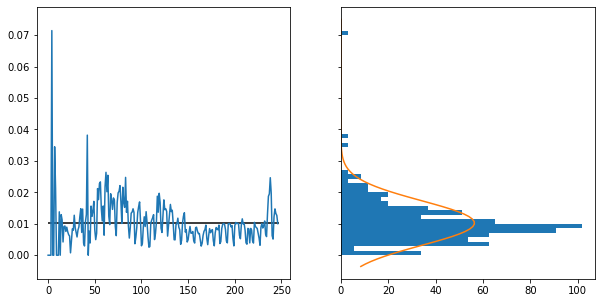

In [6]:
#let's find removal_rate(γ)

import statistics
from scipy.stats import norm

removed = [r+d for r,d in zip(recovered, deaths)]
d_removed = np.asarray([0] + [j-i for i,j in zip(removed, removed[1:])])
#removal_rate - gamma
removal_rate = [dr/i for dr, i in zip(d_removed, infected)]
removal_rate_median = statistics.median(removal_rate)
print("removal_rate_median =", removal_rate_median)

#clena outliers
removal_rate_clean = [i for i in removal_rate if i<removal_rate_median*10]

#fit normal distribution
mu, std = norm.fit(removal_rate_clean)
estim_removal_rate = mu

print("removal_rate(γ) mu =", mu)
print("days in infected(1/γ) =", 1/mu)


plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(removal_rate_clean)
ax1.hlines(mu,0,len(removal_rate_clean))
ax2.hist(removal_rate_clean, bins=50, density=True, orientation="horizontal")

xmin, xmax = ax2.get_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(p, x)
#x = np.linspace(ax2.xmin(), ax2.xmax, 100)

plt.show()

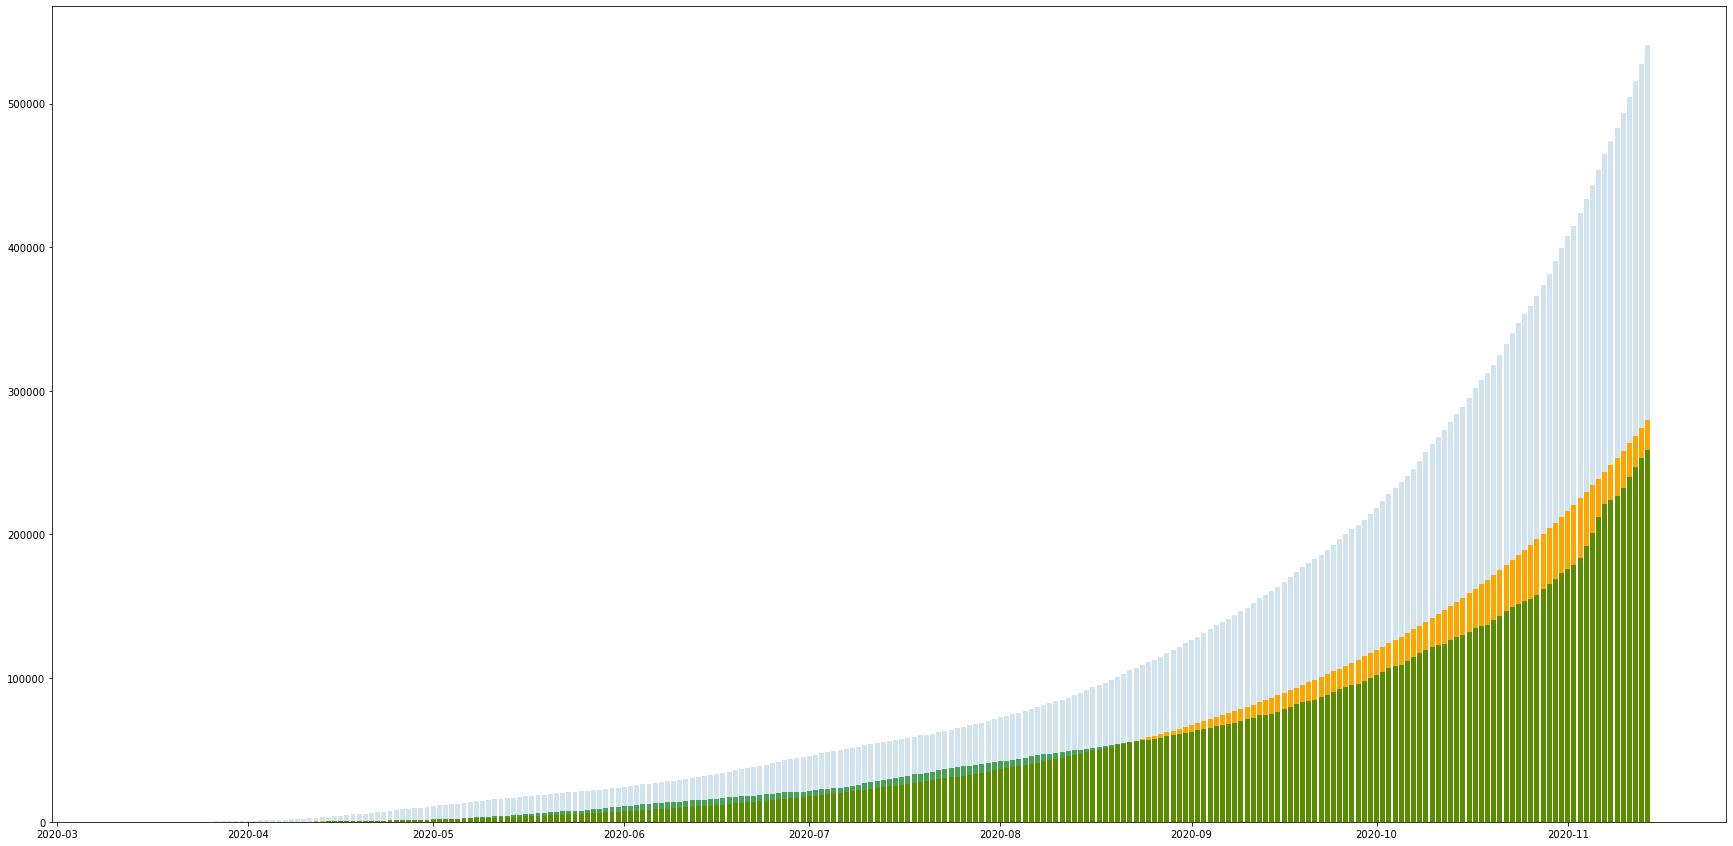

In [7]:
#visual check of calculated vs real removals

calculated_daily_recoveries = [estim_removal_rate*i for i in infected]
calculated_daily_recoveries = np.cumsum(calculated_daily_recoveries)

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, infected, alpha=0.2)
plt.bar(dates, calculated_daily_recoveries, color="orange")
plt.bar(dates, removed, color="green", alpha=0.65)

plt.show()

B_median = 0.02998077987456725
[0.66666669 0.         0.         0.57142862 0.57142866 0.
 0.12500002 0.48275878 0.40425553 0.35616466 0.         0.24742293
 0.34482811 0.26020461 0.38064638 0.14044996 0.25473809 0.14233658
 0.159691   0.19521572]
estim_infication_rate = 0.05667270704635839
hist mode = 0.026666667733333375


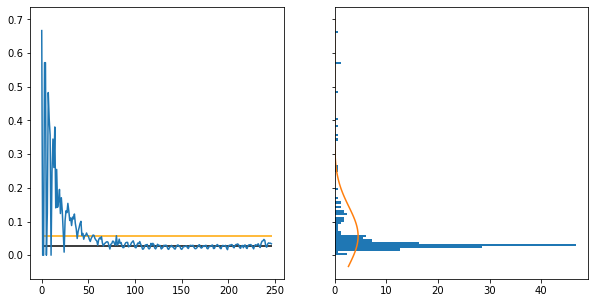

In [85]:
#https://index.minfin.com.ua/ua/reference/people/
#Nation = 41724000 #original minfin value

Nation = 100000000

d_infected = np.array(d_infected, dtype=np.float64)
d_removed = np.array(d_removed, dtype=np.float64)
infected = np.array(infected, dtype=np.float64)
removed = np.array(removed, dtype=np.float64)

B = (Nation * (d_infected + d_removed)) / (infected * (Nation - infected - removed))

B_median = statistics.median(B)
print("B_median =", B_median)

print(B[:20])

#clean outliers
#B = [i for i in B if i<B_median*80]

mu, std = norm.fit(B)
estim_infication_rate = mu
print("estim_infication_rate =", estim_infication_rate)

plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(B)
a = ax2.hist(B, bins=100, density=True, orientation="horizontal")
max_pos = [i for i, j in enumerate(a[0]) if j == max(a[0])][0]
mode = a[1][max_pos]
print("hist mode =", mode)
ax1.hlines(mode,0,len(B))
ax1.hlines(mu,0,len(B),color="orange")

xmin, xmax = ax2.get_ylim()
#ax2.set_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(p, x)
#x = np.linspace(ax2.xmin(), ax2.xmax(), 100)

plt.show()

[0.33466793 0.05558576 0.04497811]
[0.37964605 0.36155086 0.34443405 0.32824274 0.31292688 0.29843913
 0.28473472 0.2717713  0.25950879 0.24790931]


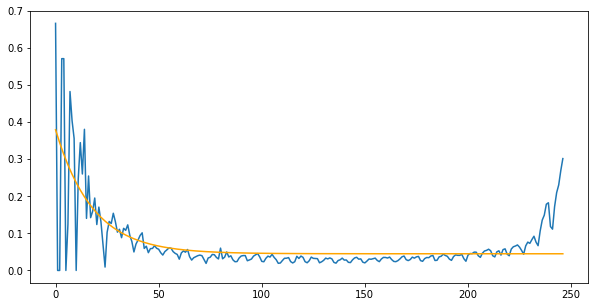

In [70]:
#approximate B as a function of time

from scipy.optimize import curve_fit

def B_of_time(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.arange(len(B))

popt, pcov = curve_fit(B_of_time, x, B, bounds=([0, 0, mode-0.1], [1., 1., mode+0.1]))
print(popt)

plt.rcParams["figure.figsize"] = [10,5]
fig = plt.figure()

plt.plot(B)

fit = B_of_time(x, *popt)
print(fit[:10])
plt.plot(fit, color="orange")

plt.show()

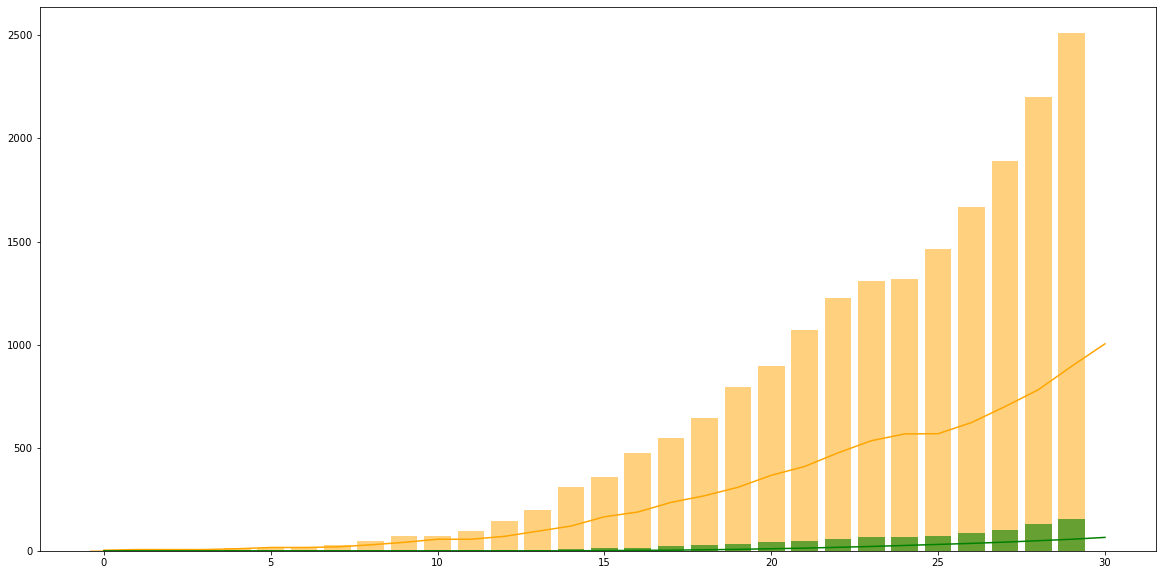

In [87]:
#reproduction_rate = estim_infication_rate / estim_removal_rate
#print("reproduction_rate =", reproduction_rate)

I = [infected[0]]
S = [Nation-I[0]]
R = [0]
days = np.arange(30)

for t in days:
    dr = int(estim_removal_rate*I[-1])
    #ds = math.ceil((B_of_time(t, *popt)) * S[-1] * I[-1] / Nation)
    ds = math.ceil((B[t]) * S[-1] * I[-1] / Nation) #debug
    #print(dr, ds, S[-1], I[-1], R[-1])
    S.append(S[-1] - ds)
    I.append(I[-1] + ds - dr)
    R.append(R[-1] + dr)
    
plt.rcParams["figure.figsize"] = [20,10]
fig = plt.figure()

#plt.plot(S)
plt.plot(I, color="orange")
plt.plot(R, color="green")

plt.bar(days[:len(infected[:len(days)])], infected[:len(days)], color="orange", alpha=0.5)
plt.bar(days[:len(removed[:len(days)])], removed[:len(days)], color="green", alpha=0.6)

plt.show()

In [82]:
a = [1,2,4]
len(a[:10])

3